###  MicroGrad demo

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from micrograd.engine import Value
from micrograd.nn import MLP

In [3]:
np.random.seed(1337)
random.seed(1337)

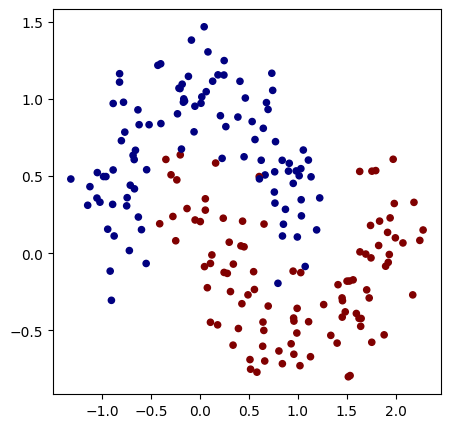

In [4]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=200, noise=0.2)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [5]:
print(X.shape)
print(y.shape)

(200, 2)
(200,)


In [6]:
# initialize a model 
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337


In [7]:
def svm_loss(batch_size=None):
    """
    Computes the Support Vector Machine (SVM) max-margin loss and accuracy for the model.
    
    This function calculates the SVM loss for a given batch of data. If `batch_size` is 
    specified, it randomly selects a minibatch of that size from the full dataset. 
    Otherwise, it uses the entire dataset. The loss includes both the SVM max-margin 
    data loss and L2 regularization to penalize large weights.

    Args:
        batch_size (int, optional): The number of samples in the minibatch. 
                                    If None, the entire dataset is used.
    
    Returns:
        tuple:
            - total_loss (Value): The total loss, combining SVM loss and regularization.
            - accuracy (float): The fraction of correct predictions in the batch.
    
    Key Components:
        1. **SVM Max-Margin Loss**:
           - For each sample, computes:
             loss = max(0, 1 - y_i * score_i)
           - Penalizes predictions that are less than 1 in the correct direction.
           - The overall loss is the mean of all individual sample losses.

        2. **L2 Regularization**:
           - Adds a penalty proportional to the squared magnitude of the model's parameters:
             reg_loss = alpha * sum(p^2)
           - Regularization parameter ( alpha = 10^{-4} ) controls the weight of this term.

        3. **Accuracy**:
           - Compares the sign of the predicted score with the true label:
             - ( prediction > 0 ) is treated as class ( +1 ).
             - ( prediction <= 0 ) is treated as class ( -1 ).
           - Calculates the fraction of correct predictions in the batch.

    Example Usage:
        total_loss, acc = svm_loss(batch_size=32)
        print("Loss:", total_loss)
        print("Accuracy:", acc)
    """
    if batch_size is None:
        Xb, yb = X, y
    else:
        # Select a random minibatch of size batch_size
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    
    # Convert input features to Value objects for autograd
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # Forward pass: compute scores using the model
    scores = list(map(model, inputs))
    
    # Compute SVM max-margin loss
    losses = [(1 + -yi * scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    
    # Compute L2 regularization loss
    alpha = 1e-4
    reg_loss = alpha * sum((p * p for p in model.parameters()))
    
    # Total loss = data loss + regularization loss
    total_loss = data_loss + reg_loss
    
    # Compute accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, float(sum(accuracy)) / len(accuracy)


In [8]:
def mse_loss(batch_size=None):
    """
    Computes the Mean Squared Error (MSE) loss and accuracy for the model.
    
    Args:
        batch_size (int, optional): The size of the minibatch. If None, uses the entire dataset.
        
    Returns:
        tuple: A tuple containing the total loss (Value) and accuracy (float).
    """
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # Forward the model to get scores
    scores = list(map(model, inputs))
    
    # Mean Squared Error (MSE) loss
    losses = [(scorei - yi)**2 for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p * p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # Also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, float(sum(accuracy)) / len(accuracy)

In [9]:
num_epochs = 100
lr = 0.01
print_interval = 2
for k in range(num_epochs):
    
    # forward
    total_loss, acc = svm_loss()
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1-0.9*k*lr
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if (k+1) % print_interval  == 0:
        print(f"[{k+1}/{num_epochs}], Loss: {total_loss.data}, Accuracy {acc*100:.3f}%")


[2/100], Loss: 1.6813590110068923, Accuracy 77.500%
[4/100], Loss: 0.7934619618809179, Accuracy 82.000%
[6/100], Loss: 0.33236347780795295, Accuracy 86.500%
[8/100], Loss: 0.2830528810729418, Accuracy 87.500%
[10/100], Loss: 0.267819295710145, Accuracy 88.000%
[12/100], Loss: 0.2558663291661101, Accuracy 90.000%
[14/100], Loss: 0.2462661145379604, Accuracy 91.000%
[16/100], Loss: 0.23910647593047843, Accuracy 90.000%
[18/100], Loss: 0.23288599542502011, Accuracy 90.500%
[20/100], Loss: 0.22649218368525637, Accuracy 91.500%
[22/100], Loss: 0.22073694831781757, Accuracy 91.000%
[24/100], Loss: 0.21737836314657896, Accuracy 91.000%
[26/100], Loss: 0.21032825464098545, Accuracy 91.500%
[28/100], Loss: 0.20565614262555745, Accuracy 91.000%
[30/100], Loss: 0.19248509293013744, Accuracy 92.000%
[32/100], Loss: 0.18314589874674983, Accuracy 93.500%
[34/100], Loss: 0.17653881893818377, Accuracy 92.500%
[36/100], Loss: 0.1703288699702829, Accuracy 92.500%
[38/100], Loss: 0.16598244856721786, Acc

(-1.800784310716395, 2.449215689283605)

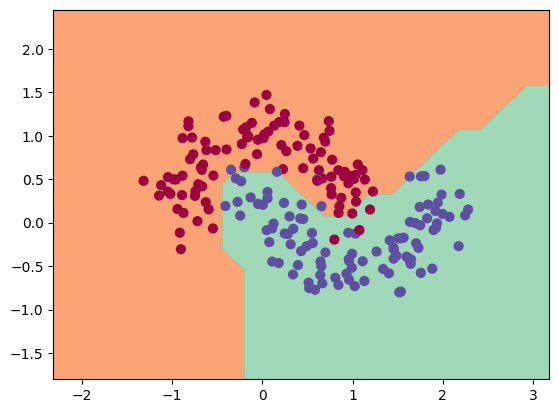

In [10]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
